In [4]:
from hedge_stand import HedgeST,send_notice
from datetime import date, datetime
from demeter import TokenInfo, PoolBaseInfo, Runner, Strategy, Asset, AccountStatus, BuyAction, SellAction, RowData, \
    ChainType
import optunity
import optunity.metrics
from decimal import Decimal
import pandas as pd
import  matplotlib.pylab as plt
# import logging 
# from logging import handlers

from strategy_ploter import  plot_position_return_decomposition

%matplotlib inline


NET_VALUE_BASE = 'ETH'
DATE_START = date(2022, 10, 30)
DATE_END = date(2022, 10, 30)

a=120
hedge_spread_split=30
hedge_spread_rate =80

# if __name__ == "__main__":
# a[105,125],hedge_spread_split[20,50], hedge_spread_rate[50,100]
# def backtest(a, hedge_spread_split,hedge_spread_rate):
pool_id_tie500 = '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640'
pool_id_tie3000 = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
eth = TokenInfo(name="eth", decimal=18)
usdc = TokenInfo(name="usdc", decimal=6)
pool = PoolBaseInfo(usdc, eth, 0.05, usdc)
#收益计算基础参数
# net_value_base = 'ETH'
runner_instance = Runner(pool)
# runner_instance.enable_notify = False
runner_instance.strategy = HedgeST(Decimal(a)/Decimal(100),Decimal(hedge_spread_split)/Decimal(10),Decimal(hedge_spread_rate)/Decimal(100))
runner_instance.set_assets([Asset(usdc, 10000)])
runner_instance.data_path = "../demeter/data"
runner_instance.load_data(ChainType.Ethereum.name,
                            pool_id_tie500,
                            DATE_START,
                           DATE_END)
runner_instance.run(enable_notify=False)
df_status = pd.DataFrame(runner_instance.account_status_list)
total_net_value = runner_instance.final_status.net_value

final_total_usdc_value = total_net_value + runner_instance.strategy.e.df['total'].iloc[-1]

# final_price = runner_instance.final_status.price
# if NET_VALUE_BASE == 'USDC':
#     return float(final_total_usdc_value)
#     # profit_rate_usdc = profit_usdc / runner_instance.strategy.init_total_usdc
# else:
#     return float(final_total_usdc_value / final_price)
    # profit_rate_eth = profit_eth / runner_instance.strategy.init_total_symbol

# df_status
# df
runner_instance.final_status





2022-11-05 21:03:12,989 - INFO - start load files from 2022-10-30 to 2022-10-30...
2022-11-05 21:03:13,036 - INFO - load file complete, preparing...
2022-11-05 21:03:13,343 - INFO - data has benn prepared
2022-11-05 21:03:13,348 - INFO - init strategy...
2022-11-05 21:03:13,432 - INFO - start main loop...


add ema column with alpha 0.05
hedge rebalance ETH -3.085951562567321304925725713 1620.245781123119277642385174 profit: 0E-51
prepare to add LP: rate:1.2 price:1620.245781123119277642385174 down:1350.204817602599398035320978 up:1944.294937347743133170862209 init symbol amount:7.406283750161571200343631264,init usdc amount:12000.00000000000011102230246
eth_value 0 usdc value 0.118199317662911314067050


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1440/1440 [00:10<00:00, 139.38it/s]
2022-11-05 21:03:23,782 - INFO - main loop finished, start calculate evaluating indicator...
2022-11-05 21:03:23,785 - INFO - run evaluating indicator
2022-11-05 21:03:23,787 - INFO - back testing finish


AccountStatus(timestamp=datetime.datetime(2022, 10, 30, 23, 59), base_balance=Decimal('0.118199317662911314067050'), quote_balance=Decimal('0'), base_uncollected=Decimal('6.594577470331889910010032299'), quote_uncollected=Decimal('0.004318149580993659543551636520'), base_in_position=Decimal('4469.225712985192038054987863'), quote_in_position=Decimal('3.414953468451397665893127801'), net_value=Decimal('9914.455039555497685062679938'), price=Decimal('1590.548267970559009042443905'))

In [7]:
e = runner_instance.strategy.e

total_net_value = runner_instance.final_status.net_value
    
final_total_usdc_value = total_net_value + runner_instance.strategy.e.df['total'].iloc[-1]


final_price = runner_instance.final_status.price
# if net_value_base == 'USDC':
profit_usdc = final_total_usdc_value- runner_instance.strategy.init_total_usdc
profit_rate_usdc = profit_usdc / runner_instance.strategy.init_total_usdc
# else:
profit_eth = final_total_usdc_value/final_price - runner_instance.strategy.init_total_symbol
profit_rate_eth = profit_eth / runner_instance.strategy.init_total_symbol

print(f"USDC profit: {profit_usdc}, profit_rate: {profit_rate_usdc}")

print(f"ETH profit: {profit_eth}, profit_rate: {profit_rate_eth}")

df_merge = pd.merge(e.df, df_status, on='timestamp', how='inner')

df_merge['total_value'] = df_merge['total'] + df_merge['net_value']

df_merge.set_index('timestamp', inplace=True)

df_merge['total_value_profit_rate'] = df_merge['total_value'] / runner_instance.strategy.init_total_usdc


df_merge['total_value_eth'] = df_merge['total_value'] / df_merge['price']

df_merge['total_value_eth_profit_rate'] = df_merge['total_value_eth'] / runner_instance.strategy.init_total_symbol

df_merge

USDC profit: -180.94004744450242595962252, profit_rate: -0.01507833728704186869046589976
ETH profit: 0.024524978224826978200946418, profit_rate: 0.003311374375076023176721826663


KeyError: 'uncollect_fee_base'

NameError: name 'df_merge' is not defined

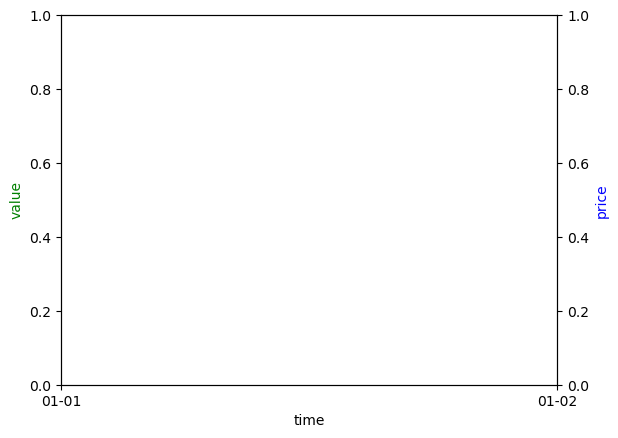

In [5]:
import matplotlib.dates as mdates

fig, value_ax = plt.subplots()
day = mdates.DayLocator(interval=7)
price_ax = value_ax.twinx()
price_ax.xaxis.set_major_locator(day)
price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

value_ax.set_xlabel('time')
value_ax.set_ylabel('value', color='g')
price_ax.set_ylabel('price', color='b')
# net_value_ts = df_merge['net_value']

time_ts = df_merge.index
price_ts = [ status.price for status in runner_instance.account_status_list ]
total_value_eth_profit_rate_ts = df_merge['total_value_eth_profit_rate']
total_value_profit_rate_ts = df_merge['total_value_profit_rate']


value_ax.plot(time_ts,total_value_eth_profit_rate_ts,'g-',label="total_value_eth_profit_rate_ts")
value_ax.plot(time_ts,total_value_profit_rate_ts,'r-',label="total_value_profit_rate_ts")
#value_ax.plot(time_ts,value_in_account,'b-',label=" value_in broker account")
price_ax.plot(time_ts,price_ts,label="price")
fig.legend()
fig.show()